In [28]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os
from astropy.constants import c
from astropy import constants as const
import astropy.units as u
from scipy import special


def weight(n):
    return 2 * n**2

def boltzmann(n1, n2, eV, T):
    k = 8.6173303e-5  # Boltzmann constant in eV/K
    g_n = weight(n2) / weight(n1) * np.exp(-eV / (k * T))
    return g_n

def CIV(T):
    sigma_Lya = 5.9e-14 * (T / 1e4) ** (-1/2)
    sigma_CIV = (0.19 / 0.4164) * sigma_Lya * (12) ** (0.5)
    N_CIV_0 = 1 / sigma_CIV
    return sigma_Lya, sigma_CIV, N_CIV_0

sig_ly, sig_c, N_CIV_0 = CIV(1e5)
print("{:.5e}".format(N_CIV_0))

def tau(sig_c, x):
    return sig_c * x

rr = np.arange(12, 18, 1)
# ee = np.arange(0,725,25)
# em = np.arange(25,725,25)
# em = np.append(1,em)
# random_v = np.arange(250,7250,250)
# random_v = np.append(118,random_v)
atom = [13,20,32,50,79]


rr_reshaped = rr.reshape(-1, 1)
total_N_c = 10**rr_reshaped * atom / 10
total_N_c = total_N_c.flatten()

C_IV_K = 1548.187e-8  # cm
C_IV_H = 1550.772e-8  # cm
cc = c.to(u.cm / u.s).value  # cm/s
cc_k = c.to(u.km / u.s).value #km / s
v_th_CIV = 11.7673179819719e5  # cm/s

K_gamma = 2.65e+8
H_gamma = 2.64e+8
f_CIV_K = 0.190
f_CIV_H = 0.0952


NN = int(1e4)
xx = np.linspace(-5, 5, NN)
yy = np.linspace(-10,10, NN)



def Voigt(x,v_th,gamma_line, lines):
    del_lam_D = v_th / lines
    a = gamma_line / (4 * np.pi * del_lam_D)
    dy = np.abs(yy[1] - yy[0])
    
    # Broadcasting and vectorized computation
    qq_minus_yy_squared = (x[:, np.newaxis] - yy)**2
    exp_neg_yy_squared = np.exp(-yy**2)
    
    summ = np.sum(exp_neg_yy_squared * dy / (qq_minus_yy_squared + a**2), axis=1)
    
    return summ * a / np.pi

def change_x_to_lam(x,v_th ,lines):
    del_lam_D = v_th / lines
    return lines / (x * v_th / cc + 1)



def N_esc_scat(v_th):
    C_iv_N = np.linspace(1e12, 1e18, NN)
    # total_tau = np.zeros((len(C_iv_N), 1e6))

    # 벡터화된 tau 및 Voigt 프로파일 계산
    Voigt_profile = Voigt(xx,v_th,K_gamma, C_IV_K)
    tau_profile = tau(sig_c, C_iv_N[:, None]) * Voigt_profile


    # x_0 계산
    x_0 = np.zeros(len(C_iv_N))
    for ii, jj in enumerate(C_iv_N):
        x_p = np.where(np.diff(np.sign(1 - tau_profile[ii, :])))[0]
        x_0[ii] = xx[x_p].max() if x_p.size > 0 else 0

    del_lam_D = v_th / C_IV_K
    nu_0_K= cc/C_IV_K
    nu_esc = x_0*del_lam_D + nu_0_K
    V_del_peak = 2 * abs((nu_esc - nu_0_K)/nu_0_K) * cc/1e5 #km/s
    v_esc = x_0*v_th
    N_esc= 1/special.erfc(v_esc/v_th)

    return C_iv_N, N_esc , V_del_peak



3.39090e+13


In [46]:
C_IV_K_A = 1548.187  # cm
C_IV_H_A = 1550.772
directory_1 = '/home/jin/data_jin/'
random_vel = np.arange(100,700,100)
random_vel= np.append(11.8,random_vel)
random_vel= [11.8,100,200]

rr = np.arange(12, 17, 1)
atom_N = [13, 20, 32, 50, 79]
rr_reshaped = rr.reshape(-1, 1)
total_N_c = 10**rr_reshaped * atom_N / 10
total_N_c = total_N_c.flatten()

check = 0
v_th_CIV = 11.7673179819719e5  # cm/s

for tt,v_ran in enumerate(random_vel):
    n = 0
    if v_ran == 11.8 :
        index_v_ran = 1
        v_title = int(v_ran*10)
        v_ran = int(v_ran*10)
    elif v_ran < 100:
        index_v_ran = 1
        v_title = int(v_ran*10)
    elif v_ran >= 1000:
        index_v_ran = 3
        v_title = int(v_ran/10)
    else :
        index_v_ran = 2
        v_title = int(v_ran)
        
    globals()[f'V_K_peak_{v_ran}'] = np.zeros(len(rr)*len(atom_N))
    globals()[f'V_H_peak_{v_ran}'] = np.zeros(len(rr)*len(atom_N))
    globals()[f'scat_{v_ran}'] = np.zeros(len(rr)*len(atom_N))
    globals()[f'xx_{v_ran}']= np.zeros(len(rr)*len(atom_N))
    iou = 1e5
    sig_ly, sig_c, N_CIV_0 = CIV(iou)
    globals()[f'C_iv_{v_ran}'],globals()[f'N_scat_{v_ran}'],globals()[f'V_del_peak_{v_ran}'] = N_esc_scat(random_vel[tt]*1e5)

    for ii, index in enumerate(rr):
        for jj, atom in enumerate(atom_N):
            path_sp = f'{directory_1}N_atom{atom}0E+{index}_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran{v_title}E+0{index_v_ran}spec_com.dat'
            path_scat = f'{directory_1}N_atom{atom}0E+{index}_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran{v_title}E+0{index_v_ran}_f_esc.dat'

            try:
                data_sp = pd.read_csv(path_sp, sep='\s+', header=None)
                data_scat = pd.read_csv(path_scat, sep='\s+', header=None)
            except FileNotFoundError:
                print(f"파일을 찾을 수 없습니다: {path_sp}")
                check += 1
                continue

            globals()[f'data_scat_{atom}_{index}_{v_ran}'] = pd.read_csv(path_scat, sep='\s+', header=None)
            
            globals()[f'scat_{v_ran}'][n] = float(globals()[f'data_scat_{atom}_{index}_{v_ran}'].iloc[0,4])
            
            # Read data
            globals()[f'data_sp_{atom}_{index}_{v_ran}'] = pd.read_csv(path_sp, sep='\s+', header=None)
            globals()[f'sp_dlam_{atom}_{index}_{v_ran}'] = globals()[f'data_sp_{atom}_{index}_{v_ran}'][0]
            globals()[f'sp_{atom}_{index}_{v_ran}'] = globals()[f'data_sp_{atom}_{index}_{v_ran}'][2]

            # K and H line separate
            lam_c = (C_IV_K_A + C_IV_H_A) / 2
            # K line
            globals()[f'lambda_K_{atom}_{index}_{v_ran}'] = globals()[f'sp_dlam_{atom}_{index}_{v_ran}'][globals()[f'sp_dlam_{atom}_{index}_{v_ran}'] <= lam_c]
            globals()[f'flux_K_{atom}_{index}_{v_ran}'] = globals()[f'sp_{atom}_{index}_{v_ran}'][globals()[f'sp_dlam_{atom}_{index}_{v_ran}'] <= lam_c]
            # H line
            globals()[f'lambda_H_{atom}_{index}_{v_ran}'] = globals()[f'sp_dlam_{atom}_{index}_{v_ran}'][globals()[f'sp_dlam_{atom}_{index}_{v_ran}'] >= lam_c]
            globals()[f'flux_H_{atom}_{index}_{v_ran}'] = globals()[f'sp_{atom}_{index}_{v_ran}'][globals()[f'sp_dlam_{atom}_{index}_{v_ran}'] >= lam_c]

            # K line double peak separate

            Fraction = 0 #0.000011
            C_IV_K_P = C_IV_K_A +  C_IV_K_A*Fraction 
            C_IV_K_N = C_IV_K_A  -  C_IV_K_A*Fraction 

            X_K_P = globals()[f'lambda_K_{atom}_{index}_{v_ran}'][globals()[f'lambda_K_{atom}_{index}_{v_ran}'] >= C_IV_K_P ].to_numpy()
            X_K_N = globals()[f'lambda_K_{atom}_{index}_{v_ran}'][globals()[f'lambda_K_{atom}_{index}_{v_ran}'] <= C_IV_K_N].to_numpy()
            filtered_series_K_pos_1 = globals()[f'flux_K_{atom}_{index}_{v_ran}'][globals()[f'lambda_K_{atom}_{index}_{v_ran}'] >= C_IV_K_P ].to_numpy()
            filtered_series_K_neg_1 = globals()[f'flux_K_{atom}_{index}_{v_ran}'][globals()[f'lambda_K_{atom}_{index}_{v_ran}'] <= C_IV_K_N].to_numpy()

            tt_K = (globals()[f'lambda_K_{atom}_{index}_{v_ran}'] <= C_IV_K_N) | (globals()[f'lambda_K_{atom}_{index}_{v_ran}'] >= C_IV_K_P )

            globals()[f'x_K_{atom}_{index}_{v_ran}'] = np.compress(tt_K, globals()[f'lambda_K_{atom}_{index}_{v_ran}'])
            globals()[f'y_K_{atom}_{index}_{v_ran}'] = np.compress(tt_K, globals()[f'flux_K_{atom}_{index}_{v_ran}'])

            # H line double peak separate
            C_IV_H_P = C_IV_H_A +  C_IV_H_A*Fraction 
            C_IV_H_N = C_IV_H_A -  C_IV_H_A*Fraction 

            X_H_P = globals()[f'lambda_H_{atom}_{index}_{v_ran}'][globals()[f'lambda_H_{atom}_{index}_{v_ran}'] >= C_IV_H_P].to_numpy()
            X_H_N = globals()[f'lambda_H_{atom}_{index}_{v_ran}'][globals()[f'lambda_H_{atom}_{index}_{v_ran}'] <= C_IV_H_N].to_numpy()
            filtered_series_H_pos_1 = globals()[f'flux_H_{atom}_{index}_{v_ran}'][globals()[f'lambda_H_{atom}_{index}_{v_ran}'] >= C_IV_H_P].to_numpy()
            filtered_series_H_neg_1 = globals()[f'flux_H_{atom}_{index}_{v_ran}'][globals()[f'lambda_H_{atom}_{index}_{v_ran}'] <= C_IV_H_N].to_numpy()

            tt_H = (globals()[f'lambda_H_{atom}_{index}_{v_ran}'] <= C_IV_H_N) | (globals()[f'lambda_H_{atom}_{index}_{v_ran}'] >= C_IV_H_P)

            globals()[f'x_H_{atom}_{index}_{v_ran}'] = np.compress(tt_H, globals()[f'lambda_H_{atom}_{index}_{v_ran}'])
            globals()[f'y_H_{atom}_{index}_{v_ran}'] = np.compress(tt_H, globals()[f'flux_H_{atom}_{index}_{v_ran}'])

            # Get peak indices
            K_p_1 = np.argmax(filtered_series_K_pos_1)
            K_n_1 = np.argmax(filtered_series_K_neg_1)

            H_p_1 = np.argmax(filtered_series_H_pos_1)
            H_n_1 = np.argmax(filtered_series_H_neg_1)

            lam_K_R = X_K_P[K_p_1]
            lam_K_B = X_K_N[K_n_1]
            
            lam_H_R = X_H_P[H_p_1]
            lam_H_B = X_H_P[H_n_1]

            Dlam = lam_K_R - lam_K_B
            vv = v_ran * 1e4

            # if vv / v_th_CIV < 1.2:
            #     dK_H = (1548.218 - 1548.156) * 1.5 
            # else:
            #     dK_H = (1548.218 - 1548.156) * 0.85 
            dK_H = 0.15
            if Dlam <= dK_H:
                del_V_peak_K = 0
            else:
                del_V_peak_K = (Dlam / C_IV_K_A) * cc / 1e5     

            globals()[f'V_K_peak_{v_ran}'][n] = del_V_peak_K
            globals()[f'xx_{v_ran}'][n] = 10**index * atom / 10
            n += 1

print(check)


0


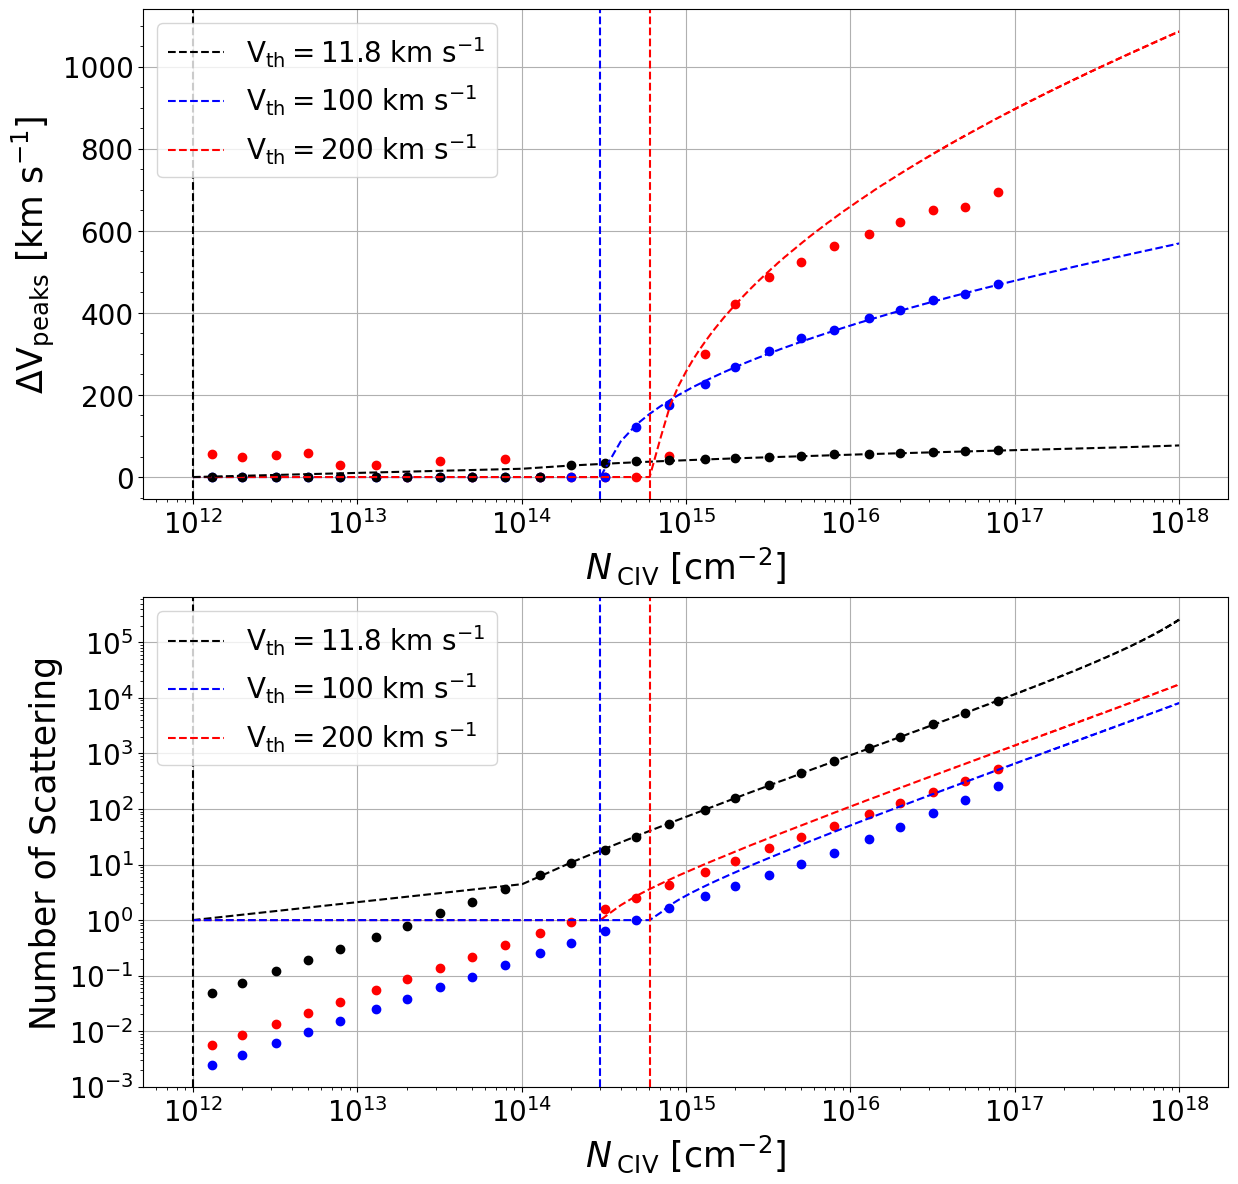

In [48]:
fig = plt.figure(1,figsize=(14,14))

plt.subplot(211)

plt.plot(xx_200,V_K_peak_200,'ro')
plt.plot(xx_100,V_K_peak_100,'bo')
# plt.plot(xx_500,V_K_peak_500,'bo')
plt.plot(xx_118,V_K_peak_118,'ko')

# plt.plot(C_iv_2000,V_del_peak_2000,'r--')
plt.plot(C_iv_100,V_del_peak_100,'b--')
plt.plot(C_iv_200,V_del_peak_200,'r--')
plt.plot(C_iv_118,V_del_peak_118,'k--')

t_1 = np.where(V_del_peak_118 == 0)[0][-1]
t_2 = np.where(V_del_peak_100 == 0)[0][-1]
t_3 = np.where(V_del_peak_200 == 0)[0][-1]

plt.axvline(x=C_iv_118[t_1],ymin=0,ymax=80,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')
plt.axvline(x=C_iv_100[t_2],ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{V_{th}}} = 100$ km s$^{-1}$')
plt.axvline(x=C_iv_200[t_3],ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{V_{th}}} = 200$ km s$^{-1}$')


# plt.axvline(x=7.58e+13,ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{V_{th}}} = 26.3$ km s$^{-1}$')
# plt.axvline(x=1.07230e+14,ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{V_{th}}} = 37.2$ km s$^{-1}$')



plt.xlabel(r'${N} \, _{\mathrm{C IV}}$ [cm$^{-2}$]',fontsize =25)
plt.xscale('log')
# plt.xlim(10**13,10**17)
# plt.ylim(V_K_peak_1.min()-2,V_K_peak_1.max()+2)
plt.ylabel(r'$\Delta \mathrm{V}_{\mathrm{peaks}}$ [km s$^{-1}$]',fontsize =25)
plt.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize=20,loc='upper left')

plt.subplot(212)
plt.plot(xx_118,scat_118,'ko')
plt.plot(C_iv_118,N_scat_118,'k--')
# plt.axvline(x=3.39e13,ymin=N_scat_118.min()-10,ymax=2,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')

plt.plot(xx_100,scat_100,'ro')
plt.plot(C_iv_100,N_scat_100,'r--')

plt.plot(xx_200,scat_200,'bo')
plt.plot(C_iv_200,N_scat_200,'b--')
# plt.axvline(x=7.58e13,ymin=N_scat_252.min()-10,ymax=2,color='b',linestyle='--',label='${\mathrm{V_{th}}} = 26.3$ km s$^{-1}$')

# plt.plot(xx_2000,scat_2000,'ro')
# plt.plot(C_iv_2000,N_scat_2000,'r--')
# plt.axvline(x=1.07e14,ymin=N_scat_372.min()-10,ymax=2,color='r',linestyle='--',label='${\mathrm{V_{th}}} = 37.2$ km s$^{-1}$')

plt.axvline(x=C_iv_118[t_1],ymin=0,ymax=80,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')
plt.axvline(x=C_iv_100[t_2],ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{V_{th}}} = 100$ km s$^{-1}$')
plt.axvline(x=C_iv_200[t_3],ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{V_{th}}} = 200$ km s$^{-1}$')


plt.xlabel(r'${N} \, _{\mathrm{C IV}}$ [cm$^{-2}$]',fontsize =25)
plt.xscale('log')
plt.yscale('log')
# plt.xlim(10**13,10**17)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.ylim(scat.min(),scat.max()+2)
plt.ylabel(r'Number of Scattering',fontsize =25)
plt.minorticks_on()
plt.grid()
plt.legend(fontsize=20,loc='upper left')


# plt.savefig('/home/jin/바탕화면/simulation_vs_analyvic_jin_test.pdf',bbox_inches="tight")



/tmp/ipykernel_6053/3940858648.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20)


Text(0.5, 0, '$\\Delta \\rm V $ [km/s]')

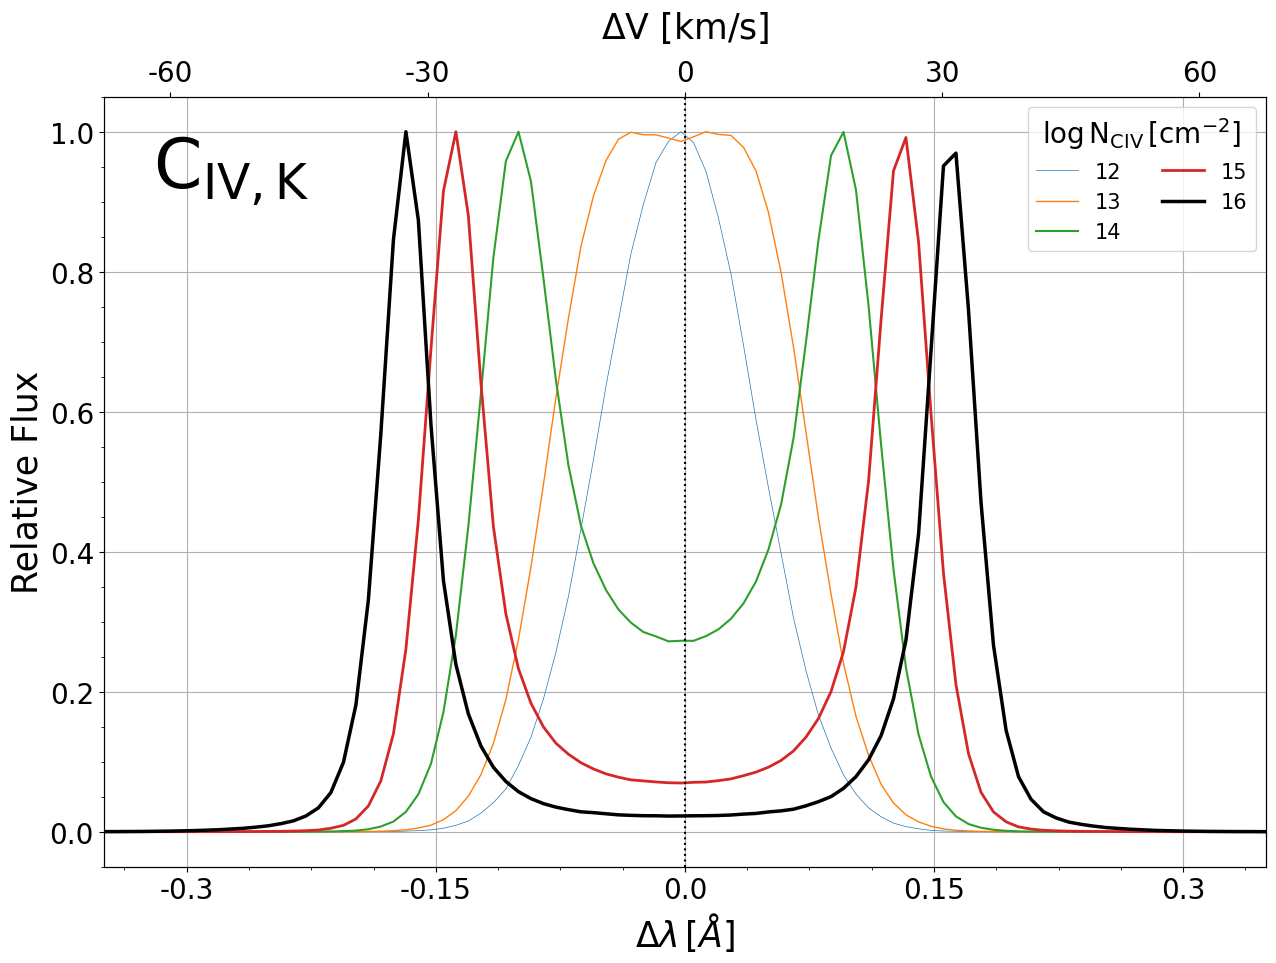

In [31]:




fig, ax1 = plt.subplots(figsize=(15, 10))



nn = 50


n_0 = 12
globals()[f'x_K_{nn}_{n_0}_118']

ax1.plot(globals()[f'x_K_{nn}_{n_0}_118'] - C_IV_K_A,globals()[f'y_K_{nn}_{n_0}_118']/globals()[f'y_K_{nn}_{n_0}_118'].max(),'-',lw=0.5,label = f'{n_0}')

n_1 = 13
ax1.plot(globals()[f'x_K_{nn}_{n_1}_118'] - C_IV_K_A,globals()[f'y_K_{nn}_{n_1}_118']/globals()[f'y_K_{nn}_{n_1}_118'].max(),'-',lw=1.0,label = f'{n_1}')

n_2 = 14
ax1.plot(globals()[f'x_K_{nn}_{n_2}_118'] - C_IV_K_A,globals()[f'y_K_{nn}_{n_2}_118']/globals()[f'y_K_{nn}_{n_2}_118'].max(),'-',lw=1.5,label = f'{n_2}')

n_3 = 15
ax1.plot(globals()[f'x_K_{nn}_{n_3}_118']-C_IV_K_A,globals()[f'y_K_{nn}_{n_3}_118']/globals()[f'y_K_{nn}_{n_3}_118'].max(),'-',lw=2,label = f'{n_3}')

n_4 = 16
ax1.plot(globals()[f'x_K_{nn}_{n_4}_118']-C_IV_K_A,globals()[f'y_K_{nn}_{n_4}_118']/globals()[f'y_K_{nn}_{n_4}_118'].max(),'k-',lw=2.5,label = f'{n_4}')




ax1.set_xlim(-0.35, 0.35)
ax1.set_xticks(np.linspace(-0.3, 0.3, 5))  # x축 눈금 설정
ax1.set_xticklabels(np.round(np.linspace(-0.3, 0.3, 5),2), fontsize=20)
# ax1.set_xticklabels(np.linspace(-0.3, 0.3, 5), fontsize=20)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20)
ax1.axvline(x=0, color='k', linestyle=':')
ax1.set_xlabel(r'$\Delta \lambda \, [\AA]$', fontsize=25)
ax1.set_ylabel('Relative Flux', fontsize=25)
ax1.legend(fontsize=15, title=r'$\log{\rm N_{\rm C IV}} \, [\rm cm^{-2}]$', title_fontsize=20, ncol=2)
ax1.minorticks_on()
ax1.grid(True)
ax1.text(-0.32, 0.92, r'$\rm C_{IV,K}$', fontweight='bold', fontsize=50)
# ax2 생성 및 설정
ax2 = ax1.twiny()

# Convert x-axis limits from angstroms to km/s
xlim = ax1.get_xlim()
vel_xlim = (np.array(xlim) / C_IV_K_A) * cc / 1e5
ax2.set_xlim(vel_xlim)

# ax2 설정
ax2.set_xticks(np.linspace(-60,60, 5))
ax2.set_xticklabels(np.linspace(-60, 60, 5).astype(int), fontsize=20)
ax2.set_xlabel(r'$\Delta \rm V $ [km/s]', fontsize=25, labelpad=15)
# plt.savefig('/home/jin/바탕화면/double_peak_K_line.pdf',bbox_inches="tight")

/tmp/ipykernel_6053/3027263626.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20)


Text(0.5, 0, '$\\Delta \\rm V $ [km/s]')

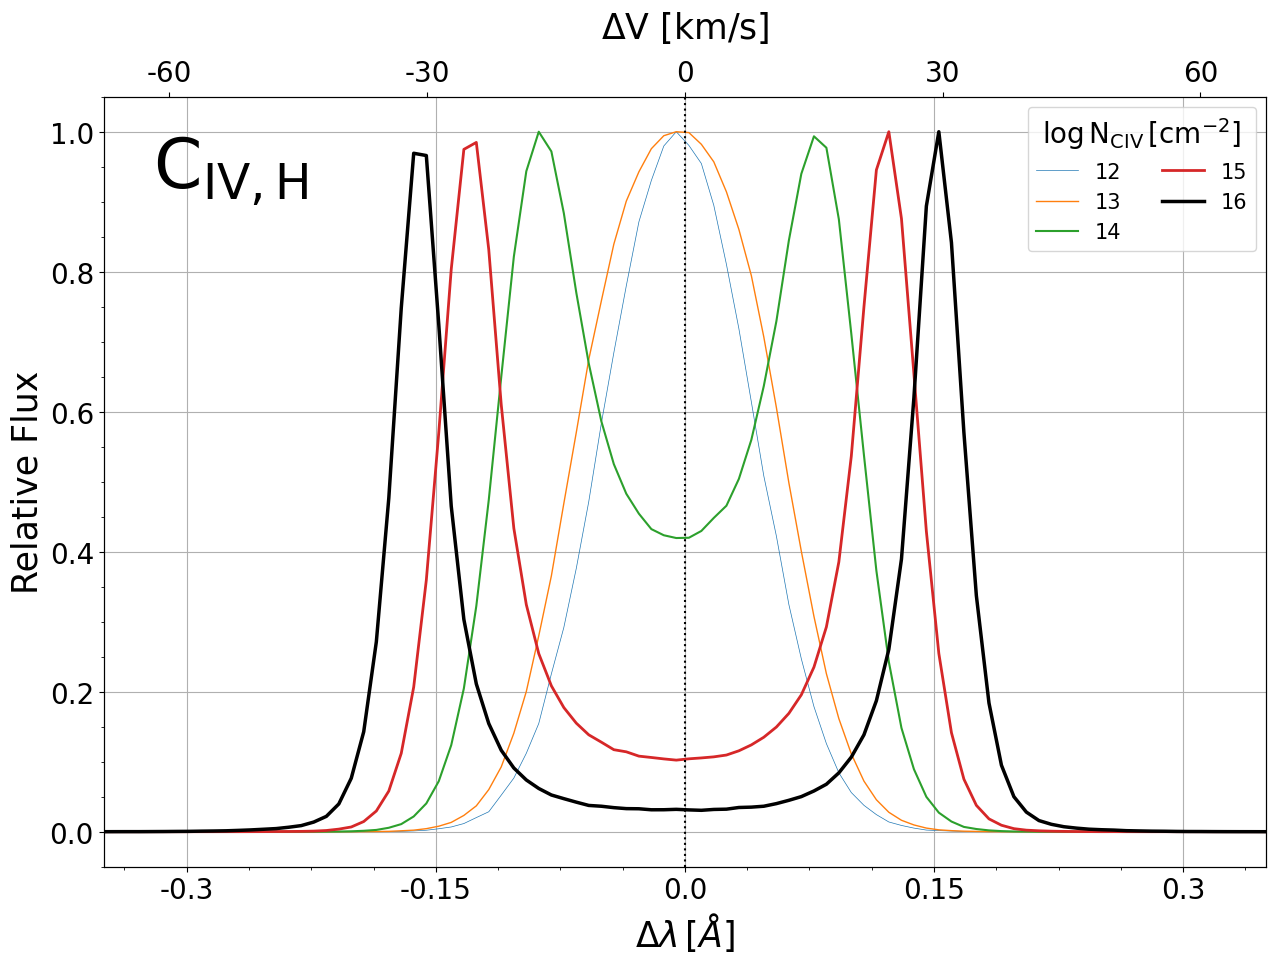

In [32]:




fig, ax1 = plt.subplots(figsize=(15, 10))



nn = 50


n_0 = 12
ax1.plot(globals()[f'x_H_{nn}_{n_0}_118'] - C_IV_H_A,globals()[f'y_H_{nn}_{n_0}_118']/globals()[f'y_H_{nn}_{n_0}_118'].max(),'-',lw=0.5,label = f'{n_0}')

n_1 = 13
ax1.plot(globals()[f'x_H_{nn}_{n_1}_118'] - C_IV_H_A,globals()[f'y_H_{nn}_{n_1}_118']/globals()[f'y_H_{nn}_{n_1}_118'].max(),'-',lw=1.0,label = f'{n_1}')

n_2 = 14
ax1.plot(globals()[f'x_H_{nn}_{n_2}_118'] - C_IV_H_A,globals()[f'y_H_{nn}_{n_2}_118']/globals()[f'y_H_{nn}_{n_2}_118'].max(),'-',lw=1.5,label = f'{n_2}')


n_3 = 15
ax1.plot(globals()[f'x_H_{nn}_{n_3}_118']-C_IV_H_A,globals()[f'y_H_{nn}_{n_3}_118']/globals()[f'y_H_{nn}_{n_3}_118'].max(),'-',lw=2,label = f'{n_3}')

n_4 = 16
ax1.plot(globals()[f'x_H_{nn}_{n_4}_118']-C_IV_H_A,globals()[f'y_H_{nn}_{n_4}_118']/globals()[f'y_H_{nn}_{n_4}_118'].max(),'k-',lw=2.5,label = f'{n_4}')



ax1.set_xlim(-0.35, 0.35)
ax1.set_xticks(np.linspace(-0.3, 0.3, 5))  # x축 눈금 설정
ax1.set_xticklabels(np.round(np.linspace(-0.3, 0.3, 5),2), fontsize=20)
# ax1.set_xticklabels(np.linspace(-0.3, 0.3, 5), fontsize=20)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20)
ax1.axvline(x=0, color='k', linestyle=':')
ax1.set_xlabel(r'$\Delta \lambda \, [\AA]$', fontsize=25)
ax1.set_ylabel('Relative Flux', fontsize=25)
ax1.legend(fontsize=15, title=r'$\log{\rm N_{\rm C IV}} \, [\rm cm^{-2}]$', title_fontsize=20, ncol=2)
ax1.minorticks_on()
ax1.grid(True)
ax1.text(-0.32, 0.92, r'$\rm C_{IV,H}$', fontweight='bold', fontsize=50)
# ax2 생성 및 설정
ax2 = ax1.twiny()

# Convert x-axis limits from angstroms to km/s
xlim = ax1.get_xlim()
vel_xlim = (np.array(xlim) / C_IV_H_A) * cc / 1e5
ax2.set_xlim(vel_xlim)

# ax2 설정
ax2.set_xticks(np.linspace(-60,60, 5))
ax2.set_xticklabels(np.linspace(-60, 60, 5).astype(int), fontsize=20)
ax2.set_xlabel(r'$\Delta \rm V $ [km/s]', fontsize=25, labelpad=15)
# ax2.grid(True)
# plt.savefig('/home/jin/바탕화면/double_peak_K_line.pdf',bbox_inches="tight")